In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import optimize

In [2]:
# --- Import all datasets ---

# Set path to dataset folder
path = "Datasets/"

# Load all datasets
equity = pd.read_csv(path + "equity_returns.csv")
esg = pd.read_csv(path + "esg_data.csv")
rf = pd.read_csv(path + "risk_free.csv")
market = pd.read_csv(path + "msci_acw.csv")

# Convert date columns to datetime
equity["Date"] = pd.to_datetime(equity["Date"])
rf["Date"] = pd.to_datetime(rf["Date"])
esg["Year"] = esg["Year"].astype(int)

# Keep only numeric return columns
returns = equity.drop(columns=["Date"])



In [3]:
# Calculate mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()

# Use average risk-free rate
rf_mean = rf["US_1m_Tbill"].mean()

# Use the most recent ESG data available
latest_esg = esg[esg["Year"] == esg["Year"].max()].drop(columns="Year").iloc[0].astype(float)

# --- Optimization function ---
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, rf):
    port_return = np.dot(weights, mean_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = ((port_return - rf) / port_std)
    return -sharpe  # minimize the negative Sharpe ratio

# --- Run optimization ---
n_assets = len(mean_returns)
init_guess = np.ones(n_assets) / n_assets
bounds = tuple((0, 1) for _ in range(n_assets))
constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}

result = optimize.minimize(
    neg_sharpe_ratio,
    init_guess,
    args=(mean_returns, cov_matrix, rf_mean),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

# --- Results ---
weights_opt = result.x
max_sharpe = -result.fun
avg_sustainability = np.dot(weights_opt, latest_esg.values)

print(f"Annulaized Maximum Sharpe ratio: {max_sharpe:.4f}")
print(f"Average sustainability score: {avg_sustainability:.2f}\n")
print("Optimal portfolio weights:\n")
for name, w in zip(mean_returns.index, weights_opt):
    if w > 0.01:  # show only weights above 1%
        print(f"{name:20s} {w:.2%}")

Annulaized Maximum Sharpe ratio: 0.6961
Average sustainability score: 59.29

Optimal portfolio weights:

NEW ZEALAND          35.62%
CZECH REPUBLIC       9.13%
RUSSIA               9.56%
COLOMBIA             24.80%
PERU                 20.88%


In [4]:
# --- Sustainability-constrained optimizations ---

# Store the unconstrained average sustainability score
base_sustainability = avg_sustainability
print(f"Baseline sustainability score: {base_sustainability:.2f}\n")

# Define a helper function that adds an ESG constraint
def optimize_with_esg_constraint(delta):
    target = base_sustainability + delta
    constraints_esg = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},                # sum of weights = 1
        {'type': 'ineq', 'fun': lambda w: np.dot(w, latest_esg) - target}  # ESG >= target
    )
    result = optimize.minimize(
        neg_sharpe_ratio,
        init_guess,
        args=(mean_returns, cov_matrix, rf_mean),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_esg
    )
    if not result.success:
        return None
    w = result.x
    sharpe = -result.fun
    avg_esg = np.dot(w, latest_esg.values)
    return sharpe, avg_esg, w

# Test deltas +2.5, +5, +7.5
deltas = [2.5, 5, 7.5]
results_esg = {}

for d in deltas:
    res = optimize_with_esg_constraint(d)
    if res is not None:
        results_esg[d] = res
    else:
        print(f"No feasible solution for +{d} points")

# --- Print results in same style as Q1 ---
print("\n--- Sharpe ratio and portfolio composition under ESG constraints ---")
for d, (sharpe, esg_score, w) in results_esg.items():
    print(f"\nΔ ESG +{d:.1f}: Sharpe ratio = {sharpe:.4f},  Avg ESG = {esg_score:.2f}")
    for name, weight in zip(mean_returns.index, w):
        if weight > 0.01:  # print only meaningful weights
            print(f"{name:20s} {weight:.2%}")


Baseline sustainability score: 59.29


--- Sharpe ratio and portfolio composition under ESG constraints ---

Δ ESG +2.5: Sharpe ratio = 0.6922,  Avg ESG = 61.79
NEW ZEALAND          45.23%
CZECH REPUBLIC       10.71%
RUSSIA               9.93%
COLOMBIA             18.90%
PERU                 15.22%

Δ ESG +5.0: Sharpe ratio = 0.6800,  Avg ESG = 64.29
NEW ZEALAND          54.29%
CZECH REPUBLIC       11.91%
RUSSIA               10.65%
COLOMBIA             13.16%
PERU                 9.40%

Δ ESG +7.5: Sharpe ratio = 0.6598,  Avg ESG = 66.79
SWITZERLAND          4.92%
NEW ZEALAND          60.17%
CZECH REPUBLIC       12.02%
RUSSIA               11.38%
COLOMBIA             7.72%
PERU                 3.78%


In [5]:
# --- Lower sustainability constraints (−2.5, −5, −7.5) ---

print(f"\nBaseline sustainability score (unconstrained): {base_sustainability:.2f}\n")

def optimize_with_lower_esg(delta):
    target = base_sustainability - delta
    constraints_esg = (
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'ineq', 'fun': lambda w: target - np.dot(w, latest_esg)}  # ESG <= target
    )
    result = optimize.minimize(
        neg_sharpe_ratio,
        init_guess,
        args=(mean_returns, cov_matrix, rf_mean),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints_esg
    )
    if not result.success:
        return None
    w = result.x
    sharpe = -result.fun
    avg_esg = np.dot(w, latest_esg.values)
    return sharpe, avg_esg, w

# Run for −2.5, −5, −7.5 points
deltas_low = [2.5, 5, 7.5]
results_esg_low = {}

for d in deltas_low:
    res = optimize_with_lower_esg(d)
    if res is not None:
        results_esg_low[d] = res
    else:
        print(f"No feasible solution for −{d} points")

# --- Print results in same style as before ---
print("\n--- Sharpe ratio and portfolio composition under lower ESG constraints ---")
for d, (sharpe, esg_score, w) in results_esg_low.items():
    print(f"\nΔ ESG −{d:.1f}: Sharpe ratio = {sharpe:.4f},  Avg ESG = {esg_score:.2f}")
    for name, weight in zip(mean_returns.index, w):
        if weight > 0.01:
            print(f"{name:20s} {weight:.2%}")



Baseline sustainability score (unconstrained): 59.29


--- Sharpe ratio and portfolio composition under lower ESG constraints ---

Δ ESG −2.5: Sharpe ratio = 0.6926,  Avg ESG = 56.79
NEW ZEALAND          25.84%
CZECH REPUBLIC       7.50%
RUSSIA               9.57%
COLOMBIA             30.66%
PERU                 26.43%

Δ ESG −5.0: Sharpe ratio = 0.6834,  Avg ESG = 54.29
NEW ZEALAND          16.18%
CZECH REPUBLIC       5.53%
RUSSIA               9.90%
COLOMBIA             36.38%
PERU                 31.65%

Δ ESG −7.5: Sharpe ratio = 0.6705,  Avg ESG = 51.79
NEW ZEALAND          7.44%
CZECH REPUBLIC       3.25%
RUSSIA               10.36%
COLOMBIA             40.27%
PERU                 34.73%
INDIA                3.95%


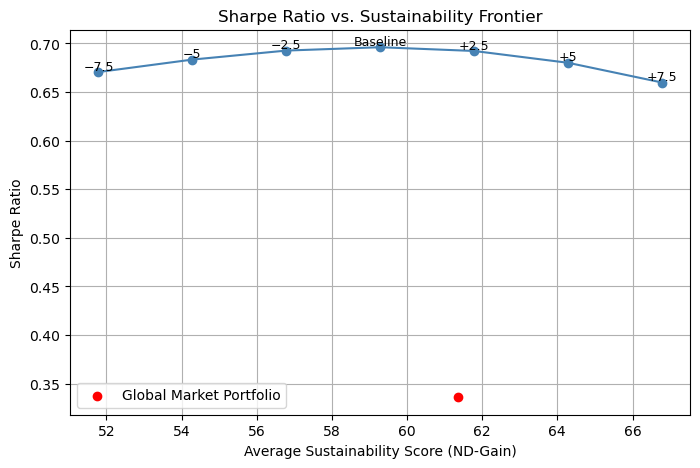

In [6]:
# Collect all portfolios (baseline, higher ESG, lower ESG)
frontier_points = []

# Baseline
frontier_points.append((avg_sustainability, -result.fun, "Baseline"))

# Higher ESG (+)
for d, (sharpe, esg_score, _) in results_esg.items():
    frontier_points.append((esg_score, sharpe, f"+{d}"))

# Lower ESG (−)
for d, (sharpe, esg_score, _) in results_esg_low.items():
    frontier_points.append((esg_score, sharpe, f"−{d}"))

# Convert to DataFrame for convenience
frontier_df = pd.DataFrame(frontier_points, columns=["ESG", "Sharpe", "Label"]).sort_values("ESG")

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(frontier_df["ESG"], frontier_df["Sharpe"], marker="o", linestyle="-", color="steelblue")

# Label each point
for _, row in frontier_df.iterrows():
    plt.text(row["ESG"], row["Sharpe"] + 0.002, row["Label"], ha="center", fontsize=9)

# Approximate MSCI ACWI weights as average country weights across dataset
equal_weights = np.ones(len(latest_esg)) / len(latest_esg)
market_esg = np.dot(equal_weights, latest_esg.values)


market_mean = market["MSCI_ACWI_Return"].mean()
market_std = market["MSCI_ACWI_Return"].std()
sharpe_market = ((market_mean - (rf_mean / 12)) / market_std) * np.sqrt(12)  # annualized Sharpe ratio
plt.scatter(market_esg, sharpe_market, color="red", label="Global Market Portfolio")

plt.title("Sharpe Ratio vs. Sustainability Frontier")
plt.xlabel("Average Sustainability Score (ND-Gain)")
plt.ylabel("Sharpe Ratio")
plt.legend()
plt.grid(True)
plt.show()
